In [1]:
from qiskit import *
from qiskit.quantum_info import *
from qiskit.circuit.library import *
import numpy as np
from numpy.testing import assert_almost_equal as aae
from functools import reduce
tensor_product = lambda *initial_state: reduce(lambda x, y: np.kron(x, y), initial_state)

from scipy import *
from scipy.linalg import *

from sympy import *

Implement state preparation using the [Schmidt Decomposition](https://arxiv.org/pdf/1003.5760.pdf)

### Multiplex Gates

In [2]:
def modified_angles(angles):
    hadamard = np.array([[1, 1], [1, -1]])
    
    dim = int(np.log2(len(angles)))
    coef_mat = tensor_product(*[hadamard]*dim) # Tensor Product of Hadamard
    modified_angles = angles@coef_mat / 2**dim
    
    return modified_angles

def multiplex_cry(circ, angles, control_bit = 0, flip = False): # Build optimized multiplexed cry gate
    
    len_angles = len(angles)
    no_qubits = circ.num_qubits
    
    if len_angles == 2 and not flip: ### Base case with Optimzation
        circ.ry(angles[0], no_qubits-1)
        circ.cx(no_qubits-2, no_qubits-1)
        circ.ry(angles[1], no_qubits-1)
        
        if no_qubits == 2:
            circ.cx(no_qubits-2, no_qubits-1)  
            
        return None
                
    elif len_angles == 2 and flip: ### Base case with Optimzation
        circ.ry(angles[1], no_qubits-1)
        circ.cx(no_qubits-2, no_qubits-1)
        circ.ry(angles[0], no_qubits-1)
        return None
    
    else: ### Recursion
        multiplex_cry(circ, angles[:len_angles//2], control_bit+1, flip = False)
        circ.cx(control_bit, no_qubits - 1)
        multiplex_cry(circ, angles[len_angles//2:], control_bit+1, flip = True)
        circ.cx(control_bit, no_qubits - 1)

def multiplex_crz(circ, angles, control_bit = 0, flip = False):
    
    """
    Build optimized multiplexed crz gate
    
    Parameters
    ----------
    circ : QuantumCircuit
        The circuit to which the multiplexed crz gate is applied.
    
    angles : list
        The list of angles to be applied to the multiplexed crz gate.
    
    control_bit : int
        The control bit for the multiplexed crz gate.
    
    flip : bool
        A boolean to determine whether the multiplexed crz gate is flipped or not.
    
    Returns
    -------
    None
        The multiplexed crz gate is applied to the circuit.
    """
    
    len_angles = len(angles)
    no_qubits = circ.num_qubits
    
    if len_angles == 2 and not flip: ### Base case with Optimzation
        circ.rz(angles[0], no_qubits-1)
        circ.cx(no_qubits-2, no_qubits-1)
        circ.rz(angles[1], no_qubits-1)
        
        if no_qubits == 2:
            circ.cx(no_qubits-2, no_qubits-1)
            
        return None
    
    elif len_angles == 2 and flip: ### Base case with Optimzation
        
        circ.rz(angles[1], no_qubits-1)
        circ.cx(no_qubits-2, no_qubits-1)
        circ.rz(angles[0], no_qubits-1)
        return None
    
    else: ### Recursion
        multiplex_crz(circ, angles[:len_angles//2], control_bit+1, flip = False)
        circ.cx(control_bit, no_qubits - 1)
        multiplex_crz(circ, angles[len_angles//2:], control_bit+1, flip = True)
        circ.cx(control_bit, no_qubits - 1)

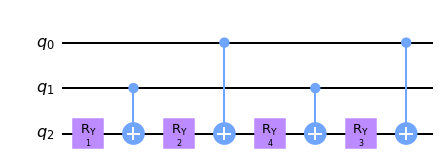

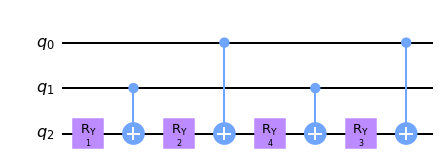

In [3]:
circ = QuantumCircuit(3)
multiplex_cry(circ, [1, 2, 3, 4])

circ.draw('mpl')

### QSD

In [4]:
def one_level_decomp(U): 
    
    '''Perform Matrix Shannon-Decomposition''' 
    
    n = int(np.log2(len(U)))

    ### Decompose U (Eq. 1)
    B, CS, A = cossin(U, p=2**(n-1), q=2**(n-1))
    A1, A2 = A[:2**(n-1), :2**(n-1)], A[2**(n-1):, 2**(n-1):]
    B1, B2 = B[:2**(n-1), :2**(n-1)], B[2**(n-1):, 2**(n-1):]
    
    ### Decompose B  (Eq. 2)
    U4, DB = diagonalize(B1@dagger(B2))
    DB = np.sqrt(DB)
    U3 = DB@dagger(U4)@B2

    ### Decompose A  (Eq. 2)
    U2, DA = diagonalize(A1@dagger(A2))
    DA = np.sqrt(DA)
    U1 = DA@dagger(U2)@A2
    
    return U4, DB, U3, CS, U2, DA, U1

### Helpful Linear Algebra Functions

def diagonalize(mat):
    
    '''Function to Diagonalize Square Matrices'''
    
    eig_val, eig_vec = np.linalg.eig(mat)
    D = np.diag(eig_val)
    V = np.block(eig_vec)
    
    return V, D

dagger = lambda mat: np.conj(mat).T  # Conjugate Transpose of a Matrix

def QSD(circ, unitary_matrix, iteration_qubits):
    
    """
    Quantum Subroutine for Quantum Shannon Decomposition
    
    This function takes a unitary matrix and decomposes it into a sequence of CX and single qubit gates.
    The decomposition is done using the Quantum Shannon Decomposition algorithm.
    
    Parameters
    ----------
    circ : QuantumCircuit
        The circuit to which the decomposition is to be applied.
    unitary_matrix : numpy.ndarray
        The unitary matrix to be decomposed.
    iteration_qubits : int
        The number of qubits in the circuit.
        
    Returns
    -------
    None
    
    """
    
    if circ.num_qubits == 1: ### Non-recursion Base Case
        circ.unitary(unitary_matrix, 0)
        return None
    
    elif circ.num_qubits == 2 or iteration_qubits == 2: ### Non-recursion Base Case
        circ.unitary(unitary_matrix, [0, 1], 'Two-Qubits')
        return None
    
    else:
        
        U4, DB, U3, CS, U2, DA, U1 = one_level_decomp(unitary_matrix)

        QSD(circ, U1, iteration_qubits-1)

        angles_DA = modified_angles(np.angle(np.diag(DA))*-2)
        
        DA_circ = QuantumCircuit(iteration_qubits)
        multiplex_crz(DA_circ, angles_DA)
        DA_circ.name = ' Multiplex Rz'
        circ.append(DA_circ, list(reversed(range(iteration_qubits-1))) + [iteration_qubits-1])
        
        QSD(circ, U2, iteration_qubits-1)

        size = int(np.log2(len(CS)))
        angles_CS = modified_angles(np.array([np.arctan2(CS[2**(size-1) + i, i], CS[i, i])*2 for i in range(2**(size-1))]))
        CS_circ = QuantumCircuit(iteration_qubits)
        multiplex_cry(CS_circ, angles_CS)
        CS_circ.name = ' Multiplex Ry'
        circ.append(CS_circ, list(reversed(range(iteration_qubits-1))) + [iteration_qubits-1])

        QSD(circ, U3, iteration_qubits-1)

        angles_DB = modified_angles(np.angle(np.diag(DB))*-2)
        DB_circ = QuantumCircuit(iteration_qubits)
        multiplex_crz(DB_circ, angles_DB)
        DB_circ.name = ' Multiplex Rz'
        circ.append(DB_circ, list(reversed(range(iteration_qubits-1))) + [iteration_qubits-1])

        QSD(circ, U4, iteration_qubits-1)

### State Prep

In [5]:
zero , one = np.array([[1], [0]]), np.array([[0], [1]])

def eq_9(psi):
    
    """Extract parameters from eq.9"""
    
    psi = psi.reshape(2, 1)

    r = np.linalg.norm(psi)

    t = np.angle(psi[0]) + np.angle(psi[1])

    phi = -np.angle(psi[0]) + np.angle(psi[1])

    theta = 2*np.arctan2(np.abs(psi[1]), np.abs(psi[0]))

    psi_test = r*np.exp(1j*t/2) * (np.exp(-1j*phi/2)*np.cos(theta/2)*zero + np.exp(1j*phi/2)*np.sin(theta/2)*one)
    
    return r, t[0], phi[0], theta[0]

### Lower bound on CX count for constructing real statevector

A general real n-qubits statevector requires $2^n-1$ parameters. When constructing real statevectors, we can only use CX gates along with $R_y$ rotations, each introducing one parameter. At the beginning, we can introduce $n$ parameters by using $n$ $R_y$ gates. For each $CX$ used, we can introduce two parameters, one $R_y$ right of the control bits, one $R_y$ right of the target bit. In general, with $k$ $CX$ gates, we can introduce $2k +n$ parameters. For larger numbers of $n$, we get a lower bound of $k = \frac{1}{2} 2^n$ in the leading order. This coincides exactly with the CX lower bound for general complex statevector using a similar argument. We can conclude that the construction statevector is as expensive as a complex construction, asymptotically.

In [6]:
def one_qubit_prep(circ, psi):
    
    _, _, phi, theta = eq_9(psi)
    
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    qc.name = ' One-Qubit '
    
    circ.append(qc, [0])
    
def stage_2(small, big):
    
    qc = QuantumCircuit(small+big)
    for control in range(small):
        qc.cx(control, control + big)
    qc.name = ' Stage 2 '
        
    return qc
    
def stage_3(A, small):
    
    qc = QuantumCircuit(small)
    QSD(qc, A, small)
    qc = qc.reverse_bits()
    qc.name = ' Stage 3 '
    
    return qc
    
def stage_4(B, big):
    
    qc = QuantumCircuit(big)
    QSD(qc, B, big)
    qc = qc.reverse_bits()
    qc.name = ' Stage 4 '
    
    return qc

In [7]:
def state_preparation(circ, psi):
    no_qubits = int(np.log2(len(psi)))
    psi = psi.reshape(2**no_qubits, 1)

    if no_qubits == 1:
        one_qubit_prep(circ, psi)
        
        return None
        
    elif no_qubits%2 == 0:
        small, big = no_qubits//2, no_qubits//2
    else:
        small, big = (no_qubits-1)//2, (no_qubits+1)//2
        
    small, big = 1, no_qubits-1

    M = psi.reshape(2**(small), 2**(big))

    U, D, V = np.linalg.svd(M)

    qc = QuantumCircuit(small) ### Recursive Step
    state_preparation(qc, D)
    qc.name = ' Stage 1 '
    
    circ.append(qc, range(small))
    
    circ.append(stage_2(small, big), range(no_qubits))
    
    circ.append(stage_3(U, small), range(small))
    
    circ.append(stage_4(V.T, big), range(small, no_qubits))

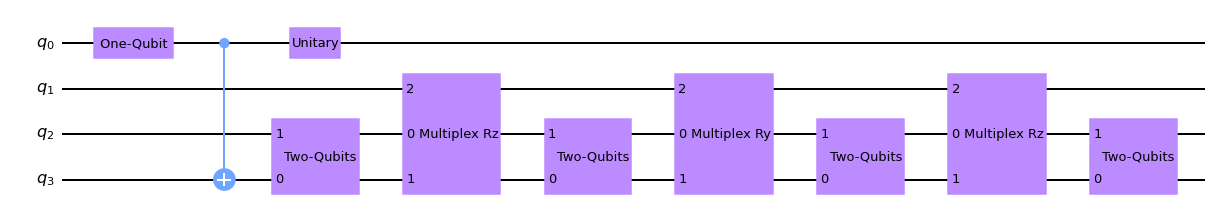

In [8]:
no_qubits = 4

psi = random_statevector(2**no_qubits).data

circ = QuantumCircuit(no_qubits)
state_preparation(circ, psi)

circ.decompose().draw('mpl')